# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

# Data Processing

### Patients CSV preprocessing

In [2]:
dtypes = {"patient_id": np.uint16, "marital_status": bool, "height_in": np.uint8, 
    "num_cohabitants": np.uint8, "dist_to_doctor_mi": np.float16, "annual_household_income": np.uint32}
df_patients = pd.read_csv('data/patients_v2.csv', index_col = 0, dtype = dtypes, parse_dates = ['dob'])
df_patients = pd.get_dummies(df_patients, columns=['sex'], prefix = 'gender',  dtype = bool)
bin_labels = ['low_income', 'middle_income', 'high_income']
df_patients['income_bracket'] = pd.qcut(df_patients.annual_household_income,
    q = [0, .25, .75, 1], labels = bin_labels)
df_patients = pd.get_dummies(df_patients, columns=['income_bracket'], prefix = 'bracket',  dtype = bool)
df_patients = df_patients.rename(columns={"dob": "patient_dob", "gender_F": "gender_female", "gender_M": "gender_male"})

### Daily Measurements preprocessing

In [3]:
dtypes = {"patient_id": np.uint16, "steps": np.int16, "diastolic": np.float16,
    "systolic": np.float16, "weight_lb": np.float16}
df_daily_measurements = pd.read_csv('data/daily_measurements_v2.csv', index_col = 0, 
    dtype = dtypes, parse_dates = ['date'])
df_daily_measurements.steps = df_daily_measurements.steps.apply(lambda x: x * -1 if x < 0 else x)
bin_labels = ['low', 'medium', 'high']
df_daily_measurements['diastolic_range'] = pd.qcut(df_daily_measurements.diastolic,
    q = [0, .05, .95, 1], labels = bin_labels)
df_daily_measurements = pd.get_dummies(df_daily_measurements, columns=['diastolic_range'], dtype = bool)
df_daily_measurements['systolic_range'] = pd.qcut(df_daily_measurements.systolic,
    q = [0, .05, .95, 1], labels = bin_labels)
df_daily_measurements = pd.get_dummies(df_daily_measurements, columns=['systolic_range'], dtype = bool)
bin_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
df_daily_measurements['steps_bracket'] = pd.qcut(df_daily_measurements.systolic,
    q = [0, .2, .4, .6, .8, 1], labels = bin_labels)
df_daily_measurements = pd.get_dummies(df_daily_measurements, columns=['steps_bracket'], dtype = bool)
df_daily_measurements = df_daily_measurements.rename( columns = {"date": "measurement_date"})

### Appointments preprocessing

In [4]:
dtypes = {"patient_id": np.uint16, "attended": bool}
df_appointments = pd.read_csv('data/appointments_v2.csv', index_col = 0, dtype = dtypes, parse_dates = ['date'])
df_appointments = pd.get_dummies(df_appointments, columns=['weather'], dtype = bool)
df_appointments = df_appointments.rename(columns={"date": "appointment_date"})

### <font color="red">DataFrame Merging & Prep for Model</font>

In [5]:
# filter measurements to day of appointment only (time-series task here; could use WMA/EWMA, days till appointment, etc.)
day_of_appointment = df_daily_measurements[(df_daily_measurements.measurement_date.isin(np.unique(df_appointments.appointment_date)))]

# now join into appointments for same day measurements, and drop the measurement date (redundant with appointment_date)
df_appointments = pd.merge(df_appointments.reset_index(), day_of_appointment.reset_index(),  how='inner', 
    left_on = ['patient_id', 'appointment_date'], right_on = ['patient_id','measurement_date'])
df_appointments.drop(columns=['measurement_date'], inplace=True)
df_appointments = df_appointments.set_index('patient_id')
df_appointments = df_appointments.merge(df_patients, how = 'inner', left_index = True, right_index = True)

# finally, calculate the age in years of the patient (at time of appointment) and drop the dates
def calculateAgeAtAppointment(appointment_date, birth_date):
    return int((appointment_date - birth_date).days / 365.2425)
df_appointments['age_year_at_time_of_appointment'] = df_appointments.apply(lambda x: calculateAgeAtAppointment(x.appointment_date, x.patient_dob), axis = 1)
df_appointments.age_year_at_time_of_appointment = df_appointments.age_year_at_time_of_appointment.astype(np.uint8)
df_appointments.drop(columns=['appointment_date', 'patient_dob'], inplace=True)

# create our x,y dataframes for model fitting and drop all prior (unnecessary) dataframes
x = df_appointments.copy().reset_index()
x = x.drop(columns=['patient_id'])
y = x.attended.values
x = x.drop(columns=['attended'])
x = x.values

del day_of_appointment, df_daily_measurements, df_patients, dtypes, bin_labels

# Model Fitting & KFold Evaluation

In [6]:
# kfold with 10 splits
kf = KFold(n_splits = 10)

# set basic prameters for LightGBM classifier and instanciate model
params = {'n_jobs':-1, 'random_state': 42, 'n_estimators': 500, 'learning_rate': 0.01}
model = lgb.LGBMClassifier(**params)

# prep dict object for saving performance of each k run
results, idx = {"k":[],"acc":[],"f1":[]}, -1

# train and measure performance of the model k-times
for train_index, test_index in kf.split(x):
    idx += 1
    model.fit(x[train_index], y[train_index], verbose = False)
    pred = model.predict(x[test_index])
    results["k"].append(idx)
    results["acc"].append(accuracy_score(y[test_index], pred))
    results["f1"].append(f1_score(y[test_index], pred))

# store final results into pandas dataframe
results = pd.DataFrame(results)

# show average accuracy and f1-score
print(f"mu acc: {np.mean(results.acc)},  mu f1: {np.mean(results.f1)}")

mu acc: 0.9420000000000002,  mu f1: 0.9657482248910492


# <font color="blue">Plot Performance of Model</font>
### <i>over K iterations</i>

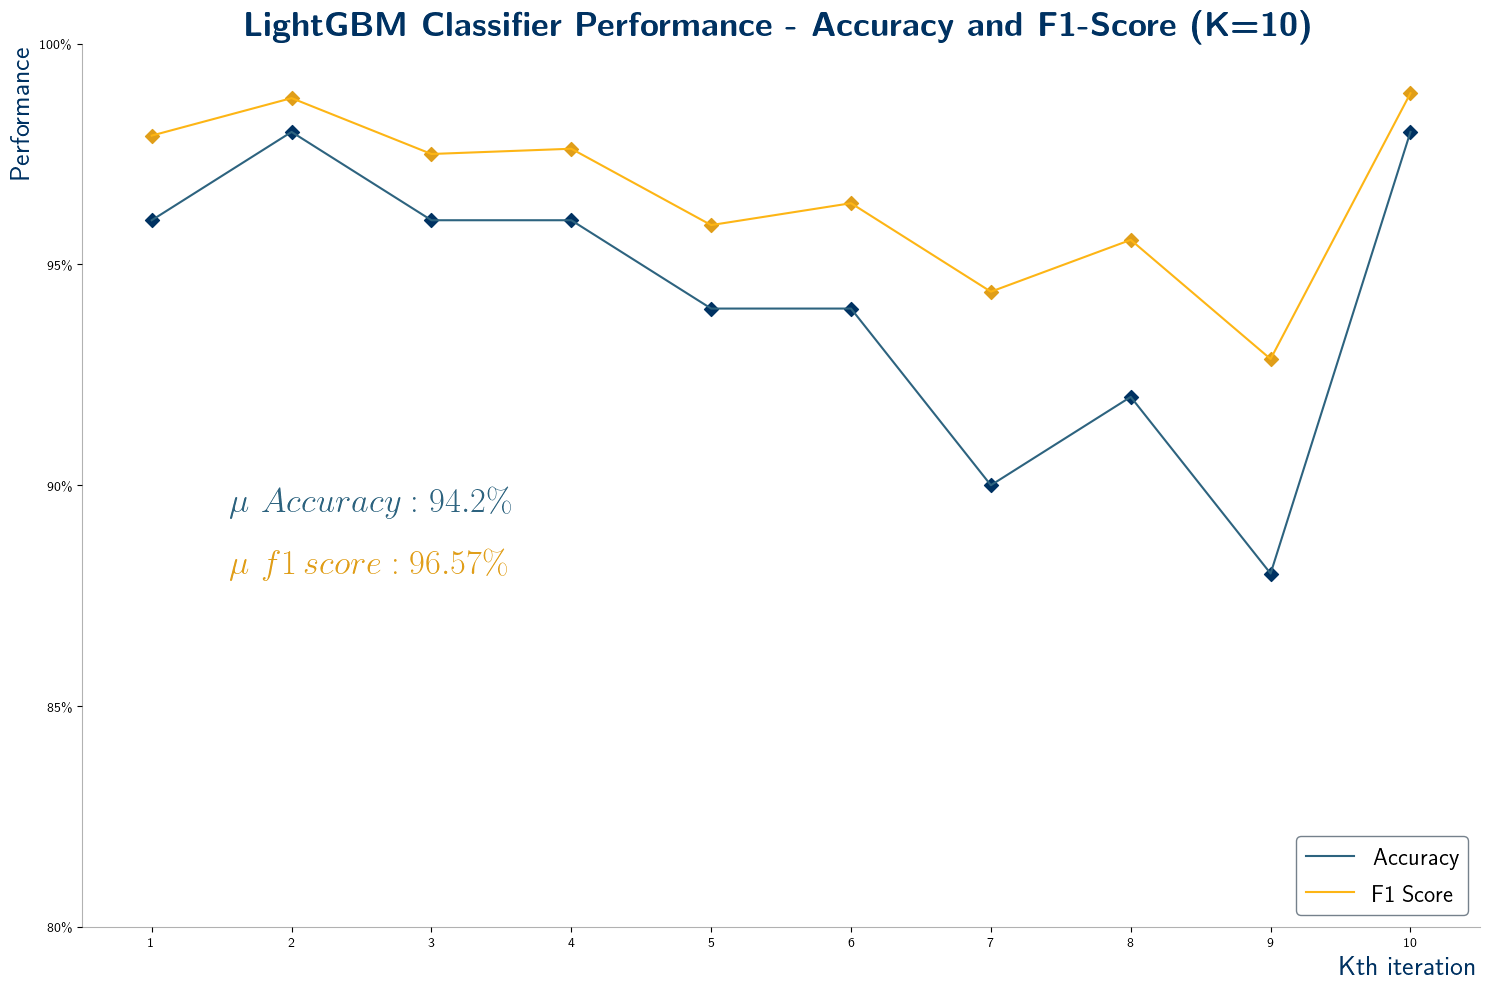

In [7]:
mu_acc, mu_f1 = round(np.mean(results.acc) * 100, 2), round(np.mean(results.f1) * 100, 2)

###########################################################################################################
## Plotting Palette
###########################################################################################################

# Create a dict object containing U.C. Berkeley official school colors for plot palette 
# reference : https://alumni.berkeley.edu/brand/color-palette
berkeley_palette = {'berkeley_blue'     : '#003262',
                    'california_gold'   : '#FDB515',
                    'metallic_gold'     : '#BC9B6A',
                    'founders_rock'     : '#2D637F',
                    'medalist'          : '#E09E19',
                    'bay_fog'           : '#C2B9A7',
                    'lawrence'          : '#00B0DA',
                    'sather_gate'       : '#B9D3B6',
                    'pacific'           : '#53626F',
                    'soybean'           : '#9DAD33',
                    'california_purple' : '#5C3160',
                    'south_hall'        : '#6C3302'}

plt.rc('text', usetex = True)
plt.rc('font', family = 'sans-serif')
f = plt.figure(figsize=(15,10), dpi = 100)
ax = f.add_subplot(111)
ax.plot(results.k, results.acc, color = berkeley_palette['founders_rock'], label = 'Accuracy')
ax.scatter(results.k, results.acc, color = berkeley_palette['berkeley_blue'], marker = 'D', s = 50)

ax.plot(results.k, results.f1, color = berkeley_palette['california_gold'], label = 'F1 Score')
ax.scatter(results.k, results.f1, color = berkeley_palette['medalist'], marker = 'D', s = 50)

# set the title and axis labels
ax.set_title(r"\textbf{LightGBM Classifier Performance - Accuracy and F1-Score (K=10)}", 
             color = berkeley_palette['berkeley_blue'], fontsize = 25, fontweight = 'bold')
ax.set_xlabel("Kth iteration", fontsize = 20, horizontalalignment='right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Performance", fontsize = 20, horizontalalignment='right', y = 1.0, color = berkeley_palette['berkeley_blue'])

# pretty up the plot axis labels and borders
ax.set_xticks(range(len(results)))
ax.set_yticks(np.arange(0.8, 1.01, .05))
ax.set_xticklabels(results.k + 1)
ax.set_yticklabels([str(int(round(i,2) * 100)) + "\%" for i in np.arange(0.8, 1.01, .05)])
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.3)

# add average annotations
ax.annotate(r"$\mu\,\,Accuracy: " + str(mu_acc) + "\%$", xy=(.105, .5),  xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 25, color = berkeley_palette['founders_rock'])

ax.annotate(r"$\mu\,\,f1\,score: " + str(mu_f1) + "\%$", xy=(.105, .43),  xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 25, color = berkeley_palette['medalist'])

# plot the legend
ax.legend(loc='lower right', fontsize = 'xx-large', fancybox = True, edgecolor = berkeley_palette['pacific'])
plt.tight_layout()
plt.show()
    

## Plot the Feature Importance of the LGB Classifier

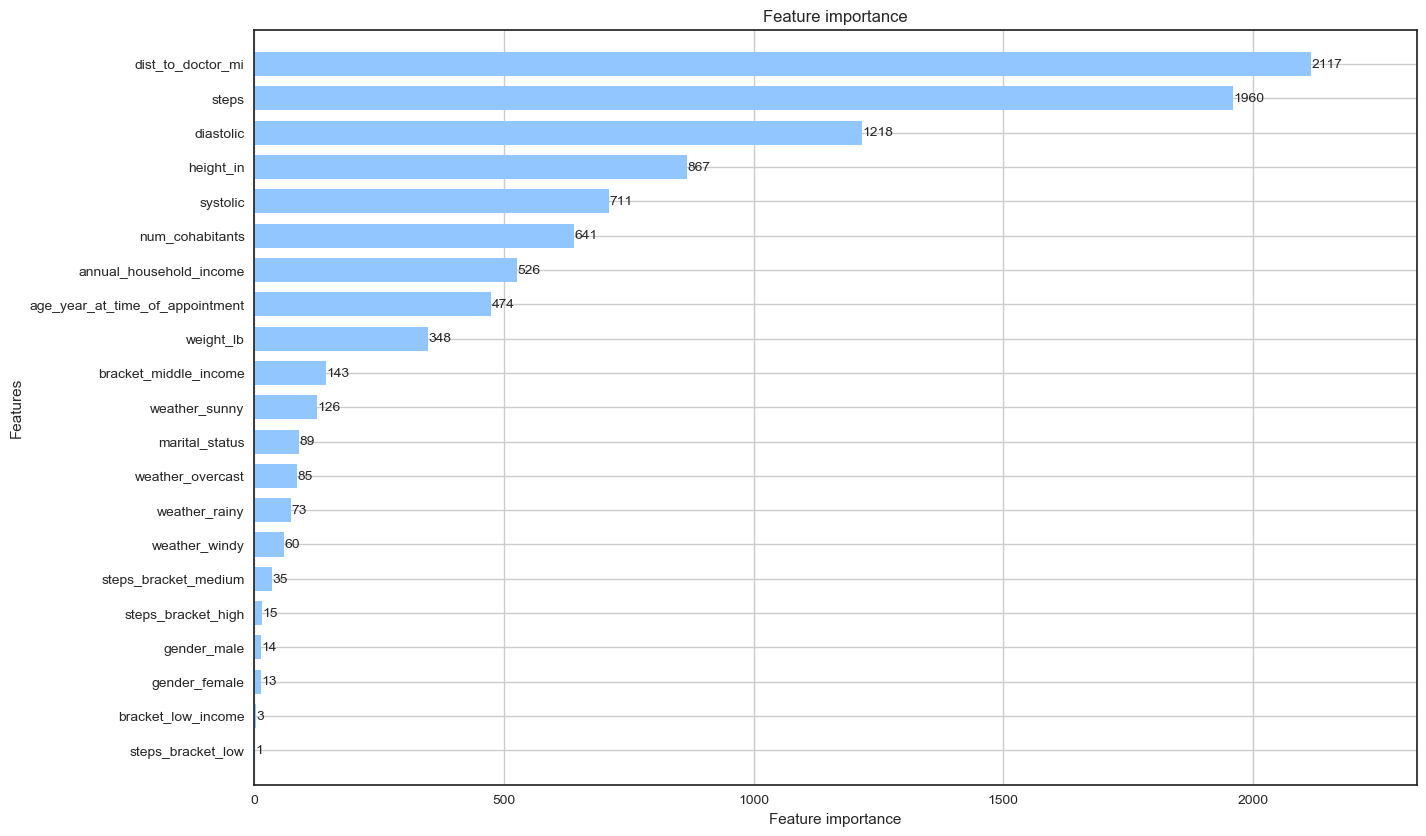

In [13]:
# train the model over the entire data-set
x = df_appointments.copy().reset_index()
x = x.drop(columns=['patient_id'])
y = x.attended.values
x = x.drop(columns=['attended'])
model.fit(x, y, verbose = False)

# plot the importance
plt.rc('text', usetex = False)
plt.style.use('seaborn-white')
f = plt.figure(figsize=(15,10), dpi = 100)
ax = f.add_subplot(111)
lgb.plot_importance(model, ax = ax, height = .7, dpi = 100)
plt.show()

# Pickle the LightGBM Classifier

In [9]:
with open('model/bby.pkl', 'wb') as f:
    pickle.dump(model, f)